In [ ]:
# ===============================
# 1. Montar o Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 2. Importação das bibliotecas
# ===============================
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil
import joblib  # Para salvar os modelos
import time  # Para capturar o tempo de execução

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

# ===============================
# 3. Definição do caminho e leitura do dataset
# ===============================
OutPath = "/content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/"
file_name = "Sinantb_desfechos5anos_03-24-2025_17-59-14.csv"
data = pd.read_csv(OutPath + file_name)

# ===============================
# 4. Visualização inicial dos dados
# ===============================
print("Visualização dos dados:")
print(data.head())
print("\nDistribuição original da coluna DESFECHO:")
print(data['DESFECHO'].value_counts())

# Separação das features (X) e da variável alvo (y)
X = data.drop("DESFECHO", axis=1)
y = data["DESFECHO"]

# Balanceamento do dataset utilizando RandomUnderSampler (undersampling)
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print("\nDistribuição após balanceamento (undersampling):")
print(pd.Series(y_res).value_counts())

# ===============================
# 5. Separação em treino e teste
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# ===============================
# 6. Definição dos parâmetros para GridSearch
# ===============================
param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

# ===============================
# 7. Treinamento com GridSearch e salvamento dos modelos
# ===============================
# Dicionário de modelos
modelos = {
    "DecisionTree": (DecisionTreeClassifier(random_state=42), param_grid_dt),
    "RandomForest": (RandomForestClassifier(random_state=42), param_grid_rf),
    "GradientBoosting": (GradientBoostingClassifier(random_state=42), param_grid_gb),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, tree_method='gpu_hist', gpu_id=0), param_grid_xgb)
}

for nome, (modelo, param_grid) in modelos.items():
    print(f"\nTreinando {nome} com GridSearchCV...")

    # Captura do horário de início para cada modelo
    start_time = time.time()

    # Aplicando GridSearchCV
    grid_search = GridSearchCV(modelo, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Captura do horário de fim para cada modelo
    end_time = time.time()

    # Cálculo do tempo de execução
    execution_time = end_time - start_time
    hours = execution_time // 3600
    minutes = (execution_time % 3600) // 60
    seconds = execution_time % 60

    # Exibindo o tempo de execução
    print(f"Tempo de treinamento para {nome}: {int(hours)} horas, {int(minutes)} minutos, {int(seconds)} segundos")

    # Resultados do GridSearchCV
    print(f"\nMelhores parâmetros para {nome}: {grid_search.best_params_}")
    print(f"Melhor score de treino para {nome}: {grid_search.best_score_}")

    # Avaliação do modelo
    y_pred = grid_search.predict(X_test)
    print(f"\nRelatório de classificação para {nome}:\n")
    print(classification_report(y_test, y_pred))

    # Salvamento do modelo otimizado
    modelo_filename = f"{OutPath}{nome}_5anos.pkl"
    joblib.dump(grid_search.best_estimator_, modelo_filename)
    print(f"Modelo {nome} otimizado salvo em: {modelo_filename}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Visualização dos dados:
   CS_SEXO  CS_RACA  CS_ESCOL_N  TRATAMENTO  AGRAVALCOO  AGRAVDIABE  \
0        2        1           9           0           2           1   
1        0        2           9           4           2           1   
2        2        4           0           0           2           1   
3        2        2           9           4           2           1   
4        2        5           8           0           1           1   

   AGRAVDOENC  AGRAVOUTRA  POP_LIBER  POP_RUA  POP_SAUDE  POP_IMIG  BENEF_GOV  \
0           1           1          1        2          1         1          6   
1           1           1          1        2          1         1          6   
2           1           1          1        2          1         1          6   
3           1           1          1        2          1         1          6   
4           1  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Visualização dos dados:
   CS_SEXO  CS_RACA  CS_ESCOL_N  TRATAMENTO  AGRAVALCOO  AGRAVDIABE  \
0        2        1           9           0           2           1   
1        0        2           9           4           2           1   
2        2        4           0           0           2           1   
3        2        2           9           4           2           1   
4        2        5           8           0           1           1   

   AGRAVDOENC  AGRAVOUTRA  POP_LIBER  POP_RUA  POP_SAUDE  POP_IMIG  BENEF_GOV  \
0           1           1          1        2          1         1          6   
1           1           1          1        2          1         1          6   
2           1           1          1        2          1         1          6   
3           1           1          1        2          1         1          6   
4           1  

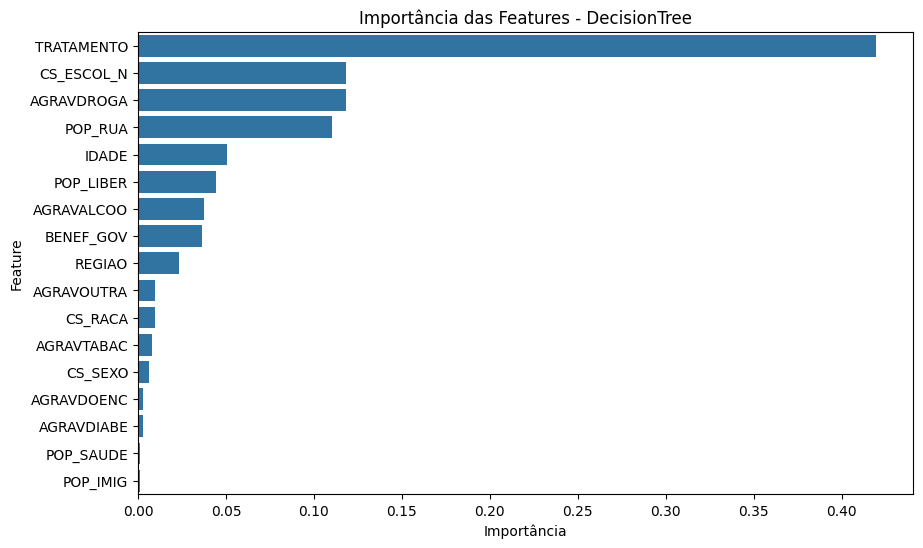

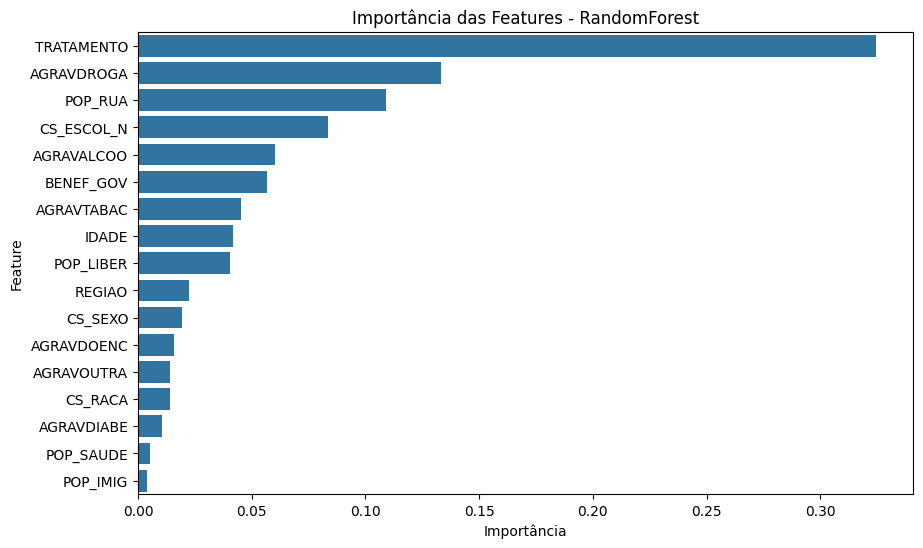

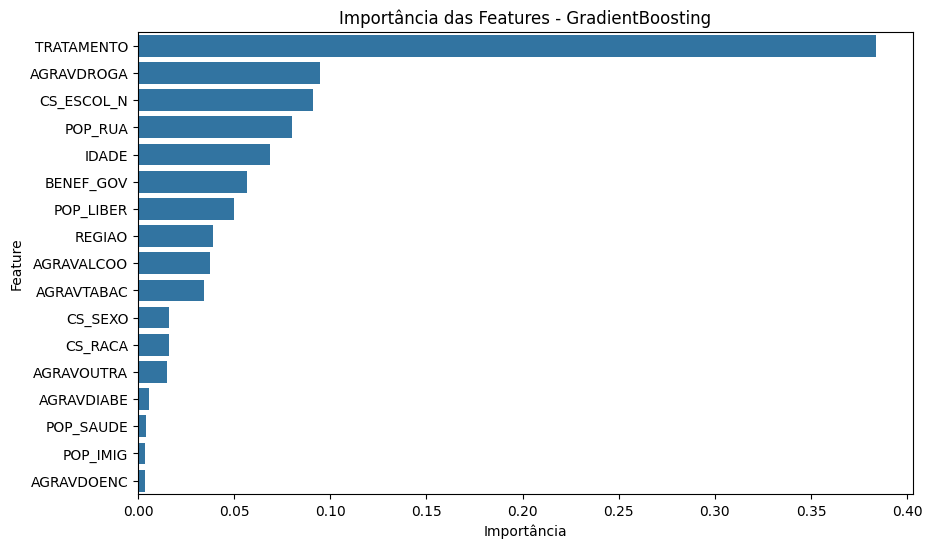

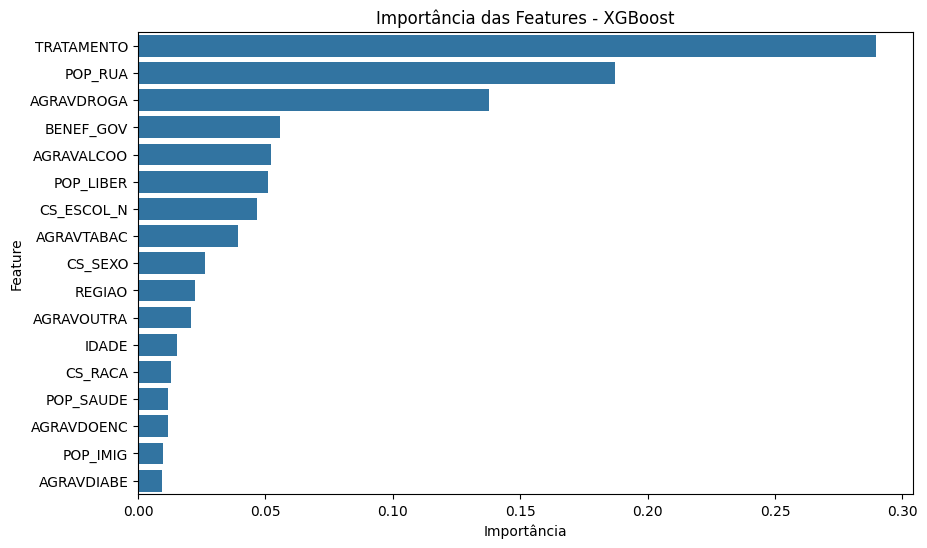

In [ ]:
# ===============================
# 1. Montar o Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 2. Importação das bibliotecas
# ===============================
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # Para carregar os modelos
import warnings
warnings.filterwarnings('ignore')

# ===============================
# 3. Definição do caminho e leitura do dataset
# ===============================
OutPath = "/content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/"
file_name = "Sinantb_desfechos5anos_03-24-2025_17-59-14.csv"
data = pd.read_csv(OutPath + file_name)

# ===============================
# 4. Visualização inicial dos dados
# ===============================
print("Visualização dos dados:")
print(data.head())

# Separação das features (X) e da variável alvo (y)
X = data.drop("DESFECHO", axis=1)
y = data["DESFECHO"]

# ===============================
# 5. Carregamento dos modelos salvos
# ===============================
model_names = ["DecisionTree", "RandomForest", "GradientBoosting", "XGBoost"]
models = {}

for model_name in model_names:
    model_path = OutPath + f"{model_name}_5anos.pkl"
    if os.path.exists(model_path):
        models[model_name] = joblib.load(model_path)
        print(f"Modelo {model_name} carregado com sucesso.")
    else:
        print(f"Modelo {model_name} não encontrado em {model_path}.")

# ===============================
# 6. Função para plotar a importância das features
# ===============================
def plot_feature_importance(model, X, model_name):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.xlabel('Importância')
    plt.title(f'Importância das Features - {model_name}')
    plt.show()

# ===============================
# 7. Geração dos gráficos de importância para cada modelo
# ===============================
for model_name, model in models.items():
    plot_feature_importance(model, X, model_name)


In [ ]:
# ===============================
# 1. Montar o Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 2. Importação das bibliotecas
# ===============================
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil
import joblib  # Para salvar os modelos
import time  # Para capturar o tempo de execução

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

# ===============================
# 3. Definição do caminho e leitura do dataset
# ===============================
OutPath = "/content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/"
file_name = "Sinantb_desfechos5anos_03-24-2025_17-59-14.csv"
data = pd.read_csv(OutPath + file_name)

# ===============================
# 4. Visualização inicial dos dados
# ===============================
print("Visualização dos dados:")
print(data.head())
print("\nDistribuição original da coluna DESFECHO:")
print(data['DESFECHO'].value_counts())

# Separação das features (X) e da variável alvo (y)
X = data.drop("DESFECHO", axis=1)
y = data["DESFECHO"]

# ===============================
# 5. Criação do conjunto de teste balanceado
# ===============================
# Objetivo: selecionar 49.433 amostras da classe minoritária e 49.433 da classe majoritária

np.random.seed(42)
class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
test_count = 49433

# Índices de cada classe
minority_indices = y[y == minority_class].index
majority_indices = y[y == majority_class].index

# Seleciona aleatoriamente test_count índices de cada classe
test_minority_indices = np.random.choice(minority_indices, size=test_count, replace=False)
test_majority_indices = np.random.choice(majority_indices, size=test_count, replace=False)

# Concatena os índices para formar o conjunto de teste
test_indices = np.concatenate([test_minority_indices, test_majority_indices])
X_test_bal = X.loc[test_indices]
y_test_bal = y.loc[test_indices]
print("\nDistribuição do conjunto de testes antes do oversampling:")
print(X_test_bal.shape,"|",y_test_bal.shape)

# O conjunto de treinamento é o restante dos dados
train_indices = list(set(X.index) - set(test_indices))
X_train_remaining = X.loc[train_indices]
y_train_remaining = y.loc[train_indices]

# ===============================
# 6. Aplicação do oversampling somente no conjunto de treinamento
# ===============================
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_remaining, y_train_remaining)
print("\nDistribuição após balanceamento (oversampling) no conjunto de treinamento:")
print(pd.Series(y_train_res).value_counts())

# ===============================
# 7. Definição dos parâmetros para GridSearch
# ===============================
param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

# ===============================
# 8. Treinamento com GridSearch e salvamento dos modelos
# ===============================
# Dicionário de modelos
modelos = {
    "DecisionTreeOS_correct": (DecisionTreeClassifier(random_state=42), param_grid_dt),
    "RandomForestOS_correct": (RandomForestClassifier(random_state=42), param_grid_rf),
    "GradientBoostingOS_correct": (GradientBoostingClassifier(random_state=42), param_grid_gb),
    "XGBoostOS_correct": (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, tree_method='gpu_hist', gpu_id=0), param_grid_xgb)
}

for nome, (modelo, param_grid) in modelos.items():
    print(f"\nTreinando {nome} com GridSearchCV...")

    # Captura do horário de início para cada modelo
    start_time = time.time()

    # Aplicando GridSearchCV
    grid_search = GridSearchCV(modelo, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_res, y_train_res)

    # Captura do horário de fim para cada modelo
    end_time = time.time()

    # Cálculo do tempo de execução
    execution_time = end_time - start_time
    hours = execution_time // 3600
    minutes = (execution_time % 3600) // 60
    seconds = execution_time % 60

    # Exibindo o tempo de treinamento
    print(f"Tempo de treinamento para {nome}: {int(hours)} horas, {int(minutes)} minutos, {int(seconds)} segundos")

    # Resultados do GridSearchCV
    print(f"\nMelhores parâmetros para {nome}: {grid_search.best_params_}")
    print(f"Melhor score de treino para {nome}: {grid_search.best_score_}")

    # Avaliação do modelo utilizando o conjunto de teste balanceado
    y_pred = grid_search.predict(X_test_bal)
    print(f"\nRelatório de classificação para {nome}:\n")
    print(classification_report(y_test_bal, y_pred))

    # Salvamento do modelo otimizado
    modelo_filename = f"{OutPath}{nome}_5anos.pkl"
    joblib.dump(grid_search.best_estimator_, modelo_filename)
    print(f"Modelo {nome} otimizado salvo em: {modelo_filename}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Visualização dos dados:
   CS_SEXO  CS_RACA  CS_ESCOL_N  TRATAMENTO  AGRAVALCOO  AGRAVDIABE  \
0        2        1           9           0           2           1   
1        0        2           9           4           2           1   
2        2        4           0           0           2           1   
3        2        2           9           4           2           1   
4        2        5           8           0           1           1   

   AGRAVDOENC  AGRAVOUTRA  POP_LIBER  POP_RUA  POP_SAUDE  POP_IMIG  BENEF_GOV  \
0           1           1          1        2          1         1          6   
1           1           1          1        2          1         1          6   
2           1           1          1        2          1         1          6   
3           1           1          1        2          1         1          6   
4           1  

In [ ]:
# ===============================
# 1. Montar o Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 2. Importação das bibliotecas
# ===============================
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil
import joblib  # Para salvar os modelos
import time  # Para capturar o tempo de execução

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE  # Alterado para SMOTE

import warnings
warnings.filterwarnings('ignore')

# ===============================
# 3. Definição do caminho e leitura do dataset
# ===============================
OutPath = "/content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/"
file_name = "Sinantb_desfechos5anos_03-24-2025_17-59-14.csv"
data = pd.read_csv(OutPath + file_name)

# ===============================
# 4. Visualização inicial dos dados
# ===============================
print("Visualização dos dados:")
print(data.head())
print("\nDistribuição original da coluna DESFECHO:")
print(data['DESFECHO'].value_counts())

# Separação das features (X) e da variável alvo (y)
X = data.drop("DESFECHO", axis=1)
y = data["DESFECHO"]

# ===============================
# 5. Criação do conjunto de teste balanceado
# ===============================
# Objetivo: selecionar 49.433 amostras da classe minoritária e 49.433 da classe majoritária

np.random.seed(42)
class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
test_count = 49433

# Índices de cada classe
minority_indices = y[y == minority_class].index
majority_indices = y[y == majority_class].index

# Seleciona aleatoriamente test_count índices de cada classe
test_minority_indices = np.random.choice(minority_indices, size=test_count, replace=False)
test_majority_indices = np.random.choice(majority_indices, size=test_count, replace=False)

# Concatena os índices para formar o conjunto de teste
test_indices = np.concatenate([test_minority_indices, test_majority_indices])
X_test_bal = X.loc[test_indices]
y_test_bal = y.loc[test_indices]
print("\nDistribuição do conjunto de testes antes do oversampling:")
print(X_test_bal.shape, "|", y_test_bal.shape)

# O conjunto de treinamento é o restante dos dados
train_indices = list(set(X.index) - set(test_indices))
X_train_remaining = X.loc[train_indices]
y_train_remaining = y.loc[train_indices]

# ===============================
# 6. Aplicação do SMOTE somente no conjunto de treinamento
# ===============================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_remaining, y_train_remaining)
print("\nDistribuição após balanceamento (SMOTE) no conjunto de treinamento:")
print(pd.Series(y_train_res).value_counts())

# ===============================
# 7. Definição dos parâmetros para GridSearch
# ===============================
param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

# ===============================
# 8. Treinamento com GridSearch e salvamento dos modelos
# ===============================
# Dicionário de modelos
modelos = {
    "DecisionTreeSMOTE": (DecisionTreeClassifier(random_state=42), param_grid_dt),
    "RandomForestSMOTE": (RandomForestClassifier(random_state=42), param_grid_rf),
    "GradientBoostingSMOTE": (GradientBoostingClassifier(random_state=42), param_grid_gb),
    "XGBoostSMOTE": (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, tree_method='gpu_hist', gpu_id=0), param_grid_xgb)
}

for nome, (modelo, param_grid) in modelos.items():
    print(f"\nTreinando {nome} com GridSearchCV...")

    # Captura do horário de início para cada modelo
    start_time = time.time()

    # Aplicando GridSearchCV
    grid_search = GridSearchCV(modelo, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_res, y_train_res)

    # Captura do horário de fim para cada modelo
    end_time = time.time()

    # Cálculo do tempo de execução
    execution_time = end_time - start_time
    hours = execution_time // 3600
    minutes = (execution_time % 3600) // 60
    seconds = execution_time % 60

    # Exibindo o tempo de treinamento
    print(f"Tempo de treinamento para {nome}: {int(hours)} horas, {int(minutes)} minutos, {int(seconds)} segundos")

    # Resultados do GridSearchCV
    print(f"\nMelhores parâmetros para {nome}: {grid_search.best_params_}")
    print(f"Melhor score de treino para {nome}: {grid_search.best_score_}")

    # Avaliação do modelo utilizando o conjunto de teste balanceado
    y_pred = grid_search.predict(X_test_bal)
    print(f"\nRelatório de classificação para {nome}:\n")
    print(classification_report(y_test_bal, y_pred))

    # Salvamento do modelo otimizado
    modelo_filename = f"{OutPath}{nome}_modelo_5anos.pkl"
    joblib.dump(grid_search.best_estimator_, modelo_filename)
    print(f"Modelo {nome} otimizado salvo em: {modelo_filename}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Visualização dos dados:
   CS_SEXO  CS_RACA  CS_ESCOL_N  TRATAMENTO  AGRAVALCOO  AGRAVDIABE  \
0        2        1           9           0           2           1   
1        0        2           9           4           2           1   
2        2        4           0           0           2           1   
3        2        2           9           4           2           1   
4        2        5           8           0           1           1   

   AGRAVDOENC  AGRAVOUTRA  POP_LIBER  POP_RUA  POP_SAUDE  POP_IMIG  BENEF_GOV  \
0           1           1          1        2          1         1          6   
1           1           1          1        2          1         1          6   
2           1           1          1        2          1         1          6   
3           1           1          1        2          1         1          6   
4           1  

Mounted at /content/drive

Distribuição do conjunto de testes:
(98866, 17) | (98866,)

Carregando modelo: DecisionTree

Classification Report para DecisionTree:

              precision    recall  f1-score   support

           0       0.68      0.54      0.60     49433
           1       0.62      0.75      0.68     49433

    accuracy                           0.64     98866
   macro avg       0.65      0.64      0.64     98866
weighted avg       0.65      0.64      0.64     98866



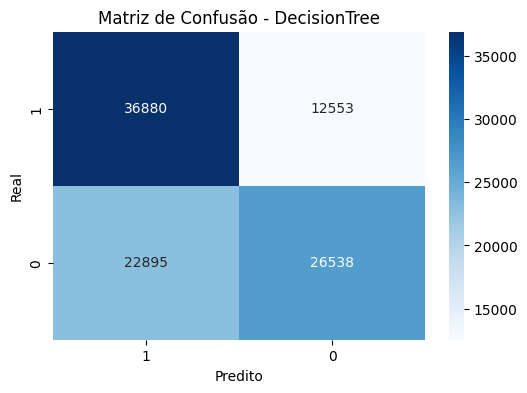


Carregando modelo: RandomForest

Classification Report para RandomForest:

              precision    recall  f1-score   support

           0       0.67      0.56      0.61     49433
           1       0.62      0.73      0.67     49433

    accuracy                           0.64     98866
   macro avg       0.65      0.64      0.64     98866
weighted avg       0.65      0.64      0.64     98866



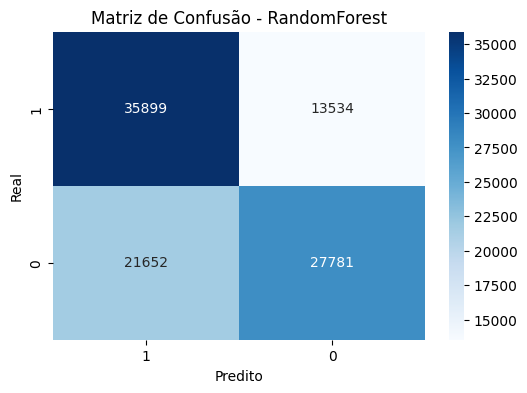


Carregando modelo: GradientBoosting

Classification Report para GradientBoosting:

              precision    recall  f1-score   support

           0       0.68      0.59      0.63     49433
           1       0.63      0.72      0.67     49433

    accuracy                           0.65     98866
   macro avg       0.65      0.65      0.65     98866
weighted avg       0.65      0.65      0.65     98866



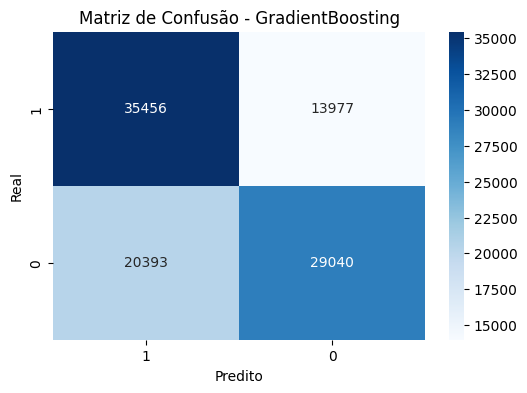


Carregando modelo: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Classification Report para XGBoost:

              precision    recall  f1-score   support

           0       0.67      0.59      0.63     49433
           1       0.63      0.72      0.67     49433

    accuracy                           0.65     98866
   macro avg       0.65      0.65      0.65     98866
weighted avg       0.65      0.65      0.65     98866



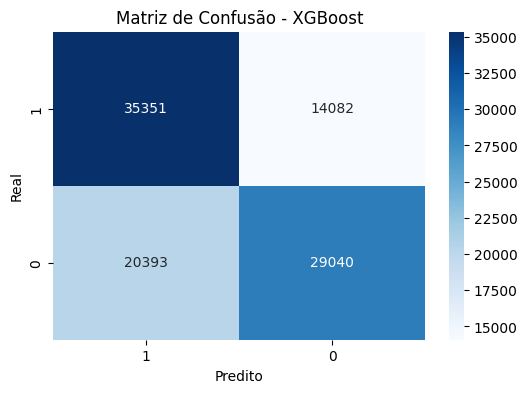


Carregando modelo: DecisionTreeOS_correct

Classification Report para DecisionTreeOS_correct:

              precision    recall  f1-score   support

           0       0.58      0.44      0.50     49433
           1       0.55      0.68      0.61     49433

    accuracy                           0.56     98866
   macro avg       0.56      0.56      0.55     98866
weighted avg       0.56      0.56      0.55     98866



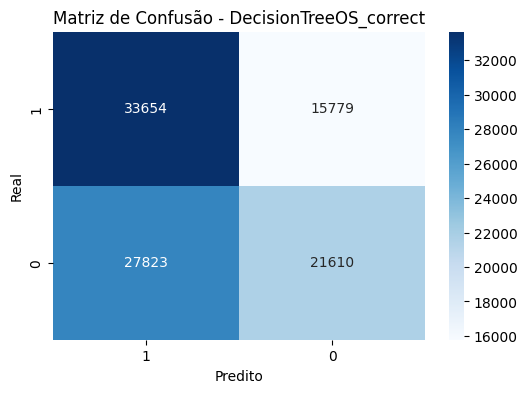


Carregando modelo: RandomForestOS_correct

Classification Report para RandomForestOS_correct:

              precision    recall  f1-score   support

           0       0.62      0.45      0.52     49433
           1       0.57      0.72      0.64     49433

    accuracy                           0.59     98866
   macro avg       0.60      0.59      0.58     98866
weighted avg       0.60      0.59      0.58     98866



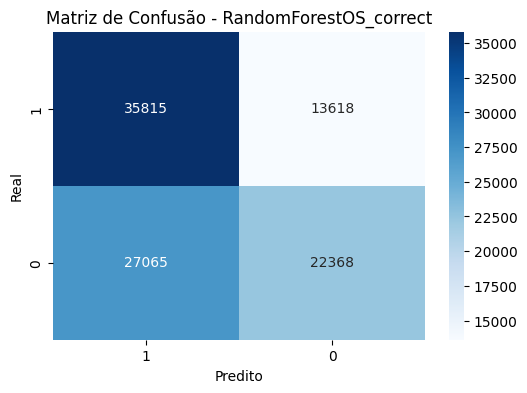


Carregando modelo: GradientBoostingOS_correct

Classification Report para GradientBoostingOS_correct:

              precision    recall  f1-score   support

           0       0.67      0.55      0.60     49433
           1       0.62      0.72      0.67     49433

    accuracy                           0.64     98866
   macro avg       0.64      0.64      0.64     98866
weighted avg       0.64      0.64      0.64     98866



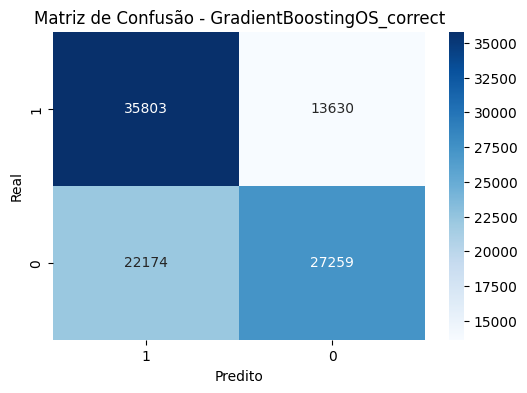


Carregando modelo: XGBoostOS_correct

Classification Report para XGBoostOS_correct:

              precision    recall  f1-score   support

           0       0.67      0.57      0.61     49433
           1       0.62      0.72      0.67     49433

    accuracy                           0.64     98866
   macro avg       0.65      0.64      0.64     98866
weighted avg       0.65      0.64      0.64     98866



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:33:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


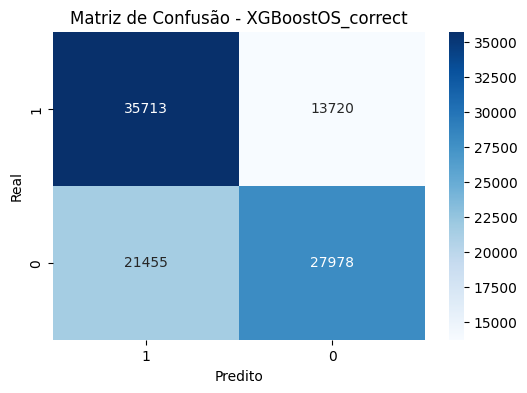


Carregando modelo: DecisionTreeSMOTE_modelo

Classification Report para DecisionTreeSMOTE_modelo:

              precision    recall  f1-score   support

           0       0.57      0.47      0.52     49433
           1       0.55      0.65      0.60     49433

    accuracy                           0.56     98866
   macro avg       0.56      0.56      0.56     98866
weighted avg       0.56      0.56      0.56     98866



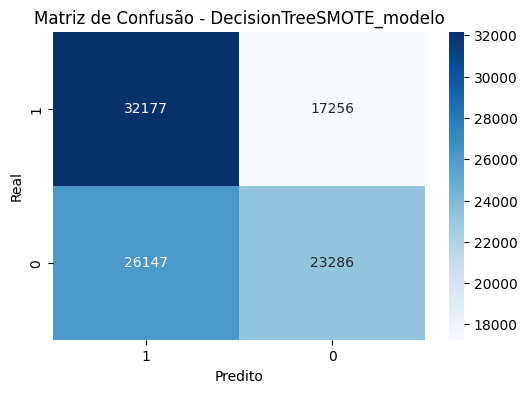


Carregando modelo: RandomForestSMOTE_modelo

Classification Report para RandomForestSMOTE_modelo:

              precision    recall  f1-score   support

           0       0.61      0.48      0.54     49433
           1       0.57      0.70      0.63     49433

    accuracy                           0.59     98866
   macro avg       0.59      0.59      0.58     98866
weighted avg       0.59      0.59      0.58     98866



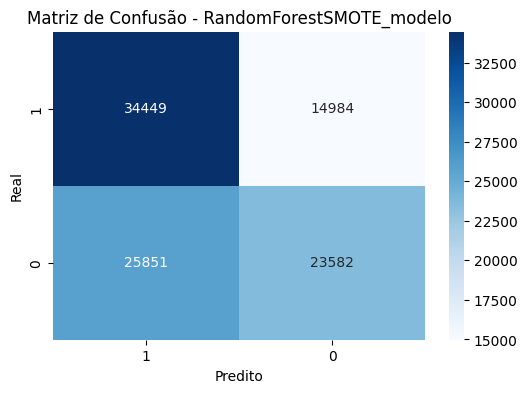


Carregando modelo: GradientBoostingSMOTE_modelo

Classification Report para GradientBoostingSMOTE_modelo:

              precision    recall  f1-score   support

           0       0.67      0.48      0.56     49433
           1       0.59      0.77      0.67     49433

    accuracy                           0.62     98866
   macro avg       0.63      0.62      0.61     98866
weighted avg       0.63      0.62      0.61     98866



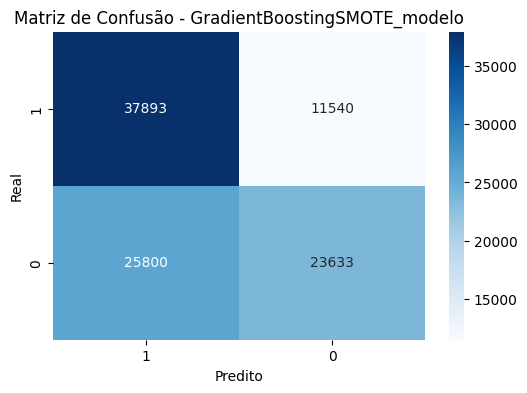


Carregando modelo: XGBoostSMOTE_modelo

Classification Report para XGBoostSMOTE_modelo:

              precision    recall  f1-score   support

           0       0.65      0.55      0.60     49433
           1       0.61      0.70      0.65     49433

    accuracy                           0.62     98866
   macro avg       0.63      0.62      0.62     98866
weighted avg       0.63      0.62      0.62     98866



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:34:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


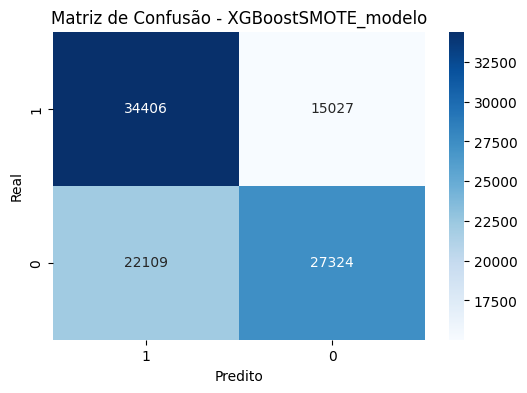


Tabela de Métricas (sem destaque):
                                       Tipo                   Modelo  \
DecisionTree                  Undersampling             DecisionTree   
RandomForest                  Undersampling             RandomForest   
GradientBoosting              Undersampling         GradientBoosting   
XGBoost                       Undersampling                  XGBoost   
DecisionTreeOS_correct         Oversampling             DecisionTree   
RandomForestOS_correct         Oversampling             RandomForest   
GradientBoostingOS_correct     Oversampling         GradientBoosting   
XGBoostOS_correct              Oversampling                  XGBoost   
DecisionTreeSMOTE_modelo              SMOTE      DecisionTree_modelo   
RandomForestSMOTE_modelo              SMOTE      RandomForest_modelo   
GradientBoostingSMOTE_modelo          SMOTE  GradientBoosting_modelo   
XGBoostSMOTE_modelo                   SMOTE           XGBoost_modelo   

                           

,Tipo,Modelo,Accuracy,Specificity,Sensitivity,F1-Macro,MCC
DecisionTree,Undersampling,DecisionTree,0.641454,0.746060,0.536848,0.637487,0.289311
RandomForest,Undersampling,RandomForest,0.644104,0.726215,0.561993,0.641688,0.292175
GradientBoosting,Undersampling,GradientBoosting,0.652358,0.717254,0.587462,0.650887,0.307315
XGBoost,Undersampling,XGBoost,0.651296,0.715130,0.587462,0.649869,0.305088
DecisionTreeOS_correct,Oversampling,DecisionTree,0.558979,0.680800,0.437157,0.552335,0.121623
RandomForestOS_correct,Oversampling,RandomForest,0.588504,0.724516,0.452491,0.580748,0.183944
GradientBoostingOS_correct,Oversampling,GradientBoosting,0.637853,0.724273,0.551433,0.635128,0.279919
XGBoostOS_correct,Oversampling,XGBoost,0.644215,0.722453,0.565978,0.642024,0.292028
DecisionTreeSMOTE_modelo,SMOTE,DecisionTree_modelo,0.560992,0.650921,0.471062,0.557412,0.124006
RandomForestSMOTE_modelo,SMOTE,RandomForest_modelo,0.586966,0.696883,0.477050,0.581915,0.178294


In [ ]:
# ===============================
# 1. Montar o Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')

# ===============================
# 2. Importação das bibliotecas
# ===============================
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, matthews_corrcoef)

# ===============================
# 3. Leitura da base de dados
# ===============================
OutPath = "/content/drive/MyDrive/Colab Notebooks/5.SINANTB_Nacional_2001-2023/1.4 Resultados e-ou arquivos de saída/"
file_name = "Sinantb_desfechos5anos_03-24-2025_17-59-14.csv"
data = pd.read_csv(os.path.join(OutPath, file_name))

# Separação das features (X) e da variável alvo (y)
X = data.drop("DESFECHO", axis=1)
y = data["DESFECHO"]

# ===============================
# 4. Criação do conjunto de teste balanceado
# ===============================
# Selecionar 49.433 amostras da classe minoritária e 49.433 da classe majoritária
np.random.seed(42)
class_counts = y.value_counts()
minority_class = class_counts.idxmin()  # Classe minoritária (definida como positiva)
majority_class = class_counts.idxmax()    # Classe majoritária (definida como negativa)
test_count = 49433

# Índices de cada classe
minority_indices = y[y == minority_class].index
majority_indices = y[y == majority_class].index

# Seleciona aleatoriamente os índices para cada classe
test_minority_indices = np.random.choice(minority_indices, size=test_count, replace=False)
test_majority_indices = np.random.choice(majority_indices, size=test_count, replace=False)

# Concatena os índices para formar o conjunto de teste
test_indices = np.concatenate([test_minority_indices, test_majority_indices])
X_test_bal = X.loc[test_indices]
y_test_bal = y.loc[test_indices]
print("\nDistribuição do conjunto de testes:")
print(X_test_bal.shape, "|", y_test_bal.shape)

# ===============================
# 5. Lista dos nomes dos modelos
# ===============================
# Modelos informados:
# Para Undersampling:
#   "DecisionTree", "RandomForest", "GradientBoosting", "XGBoost"
#
# Para Oversampling:
#   "DecisionTreeOS_correct", "RandomForestOS_correct", "GradientBoostingOS_correct", "XGBoostOS_correct"
#
# Para SMOTE:
#   "DecisionTreeSMOTE", "RandomForestSMOTE", "GradientBoostingSMOTE", "XGBoostSMOTE"
model_names = [
    "DecisionTree",
    "RandomForest",
    "GradientBoosting",
    "XGBoost",
    "DecisionTreeOS_correct",
    "RandomForestOS_correct",
    "GradientBoostingOS_correct",
    "XGBoostOS_correct",
    "DecisionTreeSMOTE_modelo",
    "RandomForestSMOTE_modelo",
    "GradientBoostingSMOTE_modelo",
    "XGBoostSMOTE_modelo"
]

# ===============================
# 6. Carregar os modelos, fazer predições e armazenar métricas
# ===============================
model_dir = OutPath  # Atualize se os modelos estiverem em outro diretório
metrics_results = {}  # Dicionário para armazenar as métricas

for model_name in model_names:
    model_file = os.path.join(model_dir, f"{model_name}_5anos.pkl")

    if os.path.exists(model_file):
        print(f"\nCarregando modelo: {model_name}")
        model = joblib.load(model_file)

        # Realiza a predição no conjunto de teste balanceado
        y_pred = model.predict(X_test_bal)

        # Exibe o Classification Report (opcional)
        print(f"\nClassification Report para {model_name}:\n")
        print(classification_report(y_test_bal, y_pred))

        # Calcula e plota a Matriz de Confusão
        # Definindo a ordem: [classe negativa, classe positiva]
        cm = confusion_matrix(y_test_bal, y_pred, labels=[majority_class, minority_class])
        TN, FP, FN, TP = cm.ravel()
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[majority_class, minority_class],
                    yticklabels=[majority_class, minority_class])
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.title(f"Matriz de Confusão - {model_name}")
        plt.show()

        # Cálculo das métricas
        acc = accuracy_score(y_test_bal, y_pred)
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0  # Sensibilidade (recall da classe positiva)
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0      # Especificidade (recall da classe negativa)
        f1_macro = f1_score(y_test_bal, y_pred, average='macro')
        mcc = matthews_corrcoef(y_test_bal, y_pred)

        metrics_results[model_name] = {
            "Accuracy": acc,
            "Specificity": specificity,
            "Sensitivity": sensitivity,
            "F1-Macro": f1_macro,
            "MCC": mcc
        }
    else:
        print(f"Arquivo do modelo não encontrado: {model_file}")

# ===============================
# 7. Criação da tabela de métricas com coluna "Tipo" e nomes limpos
# ===============================
df_metrics = pd.DataFrame(metrics_results).T  # Linhas: modelos; colunas: métricas

# Funções auxiliares para definir o tipo de experimento e limpar os nomes dos modelos
def get_experiment(model_name):
    if "OS_correct" in model_name:
        return "Oversampling"
    elif "SMOTE" in model_name:
        return "SMOTE"
    else:
        return "Undersampling"

def clean_model_name(model_name):
    # Remove os sufixos "OS_correct" e "SMOTE"
    return model_name.replace("OS_correct", "").replace("SMOTE", "")

# Adiciona as colunas "Tipo" e "Modelo"
df_metrics["Tipo"] = [get_experiment(model) for model in df_metrics.index]
df_metrics["Modelo"] = [clean_model_name(model) for model in df_metrics.index]

# Reordena as colunas para que "Tipo" e "Modelo" fiquem à esquerda
df_metrics = df_metrics[["Tipo", "Modelo", "Accuracy", "Specificity", "Sensitivity", "F1-Macro", "MCC"]]

print("\nTabela de Métricas (sem destaque):")
print(df_metrics)

# ===============================
# 8. Destaque dos melhores valores em cada coluna de métricas
# ===============================
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

# Aplica o estilo para destacar (em negrito) o maior valor de cada coluna de métricas
df_metrics_styled = df_metrics.style.apply(highlight_max, subset=["Accuracy", "Specificity", "Sensitivity", "F1-Macro", "MCC"])

print("\nTabela de Métricas com Destaque (em ambiente que suporte HTML, como Jupyter/Colab):")
display(df_metrics_styled)
